# Filtering and parsing string-db for COAD associated interactions

Download string-db for humans from [here]([https://string-db.org/cgi/download?sessionId=bpHd4Ji7A7W6&species_text=Homo+sapiens&settings_expanded=0&min_download_score=0&filter_redundant_pairs=0&delimiter_type=txt]) to same directory as this notebook.

And download the CPTAC data [here](https://cptac-pancancer-data.s3.us-west-2.amazonaws.com/data_freeze_v1.2_reorganized/zip_files/COAD.zip) to same directory as this notebook.

Strategy:
- Identify top 50 genes associated with CPTAC from Open Targets Platform
- Subset interaction database to only include interactions that include at least one of these CPTAC associated genes
- Remove interactions with score < 400 (this is an arbitrary threshold for now, but this can be made more statistically rigorous)
- Cross-reference proteins against those measured in CPTAC phosphoproteomics (the rationale for this is that we want to use actual patient omics data for prediction, so the graph should be restricted to genes/proteins for which we will have measurements), and keep only those interactions where both proteins are present in the CPTAC data. **This is the final relevant PPI for the graph neural network to take as input**

In [1]:
import matplotlib.pyplot as plt
from typing import List, Set
import numpy as np
import pandas as pd
import requests


In [2]:
def subset_interaction_db(
    input_file: str,
    output_file: str,
    proteins_of_interest: List[str],
    how: str = "either",
    delimiter: str = " "
):
    """
    Subset a protein-protein interaction file:
    - Removes the '9606.' prefix from protein IDs
    - Keeps only rows with proteins of interest
    - Tracks and returns all scores for distribution analysis
    
    Args:
        input_file: Path to the PPI file (with header).
        output_file: Path to save filtered results.
        proteins_of_interest: List of protein IDs (without 9606. prefix).
        delimiter: Column separator (default: space).
    
    Returns:
        List of scores (floats).
    """
    poi_set: Set[str] = set(proteins_of_interest)
    scores = []

    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        header = infile.readline().strip().split(delimiter)
        outfile.write(delimiter.join(header) + "\n")  # write header

        for line in infile:
            parts = line.strip().split(delimiter)
            if len(parts) < 3:
                continue  # skip malformed lines

            p1 = parts[0]
            p2 = parts[1]
            score = float(parts[2])
            
            if how == "either":
                if (p1 in poi_set) | (p2 in poi_set):
                    outfile.write(f"{p1}{delimiter}{p2}{delimiter}{score}\n")
                    scores.append(score)

            else:
                if (p1 in poi_set) & (p2 in poi_set):
                    outfile.write(f"{p1}{delimiter}{p2}{delimiter}{score}\n")
                    scores.append(score)

    return scores

In [3]:
def plot_score_distribution(scores, bins=50):
    """Plot histogram of scores."""
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins=bins, edgecolor="black", alpha=0.7)
    plt.xlabel("PPI Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Protein-Protein Interaction Scores\nfor Involving COAD-associated Proteins from Open Targets")
    plt.show()

In [4]:
def map_genes_to_string_ids(gene_list, species=9606):
    """
    Maps the gene names to canonical protein IDs.
    Note that this is information from String-DB. 
    """
    url = "https://string-db.org/api/json/get_string_ids"
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": species
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    
    mapping = {}
    for entry in data:
        mapping[entry["queryItem"]] = entry["stringId"]  # e.g., "9606.ENSP00000269305"
    return mapping


These are the top 50 genes associated with COAD in Open Targets Platform

In [5]:
top_associated_genes = ["APC", "KRAS", "EGFR", "BRAF", "PIK3CA", "FBXW7", "TP53", "TCF7L2", "ERBB2","ATM", 
                        "AMER1", "MET", "SMAD4", "NRAS", "MSH6", "PTEN", "ARID1A", "RNF43", "NTRK1", "SMAD2", 
                        "ERBB3", "AKT1", "BCL9L","FBXO11","POLE","GNAS","KDR","MLH1","MSH2","ACVR2A",
                        "MAP2K1","PIK3R1","SMAD3","ALK","MUTYH","FLT4","TGFBR2","RBM10","MTOR","AR",
                        "TERT","PMS2","USP6","BCORL1","PCBP1","FAT4","EP300","RAF1","BCOR","PDGFRB"]

In [6]:
ensembleIDs = map_genes_to_string_ids(top_associated_genes)

In [7]:
scores = subset_interaction_db(input_file="./9606.protein.links.v12.0.txt", 
                               output_file="./open.targets.COAD.associated.protein.links.txt", 
                               proteins_of_interest=list(ensembleIDs.values()))

In [8]:
scores = np.array(scores)

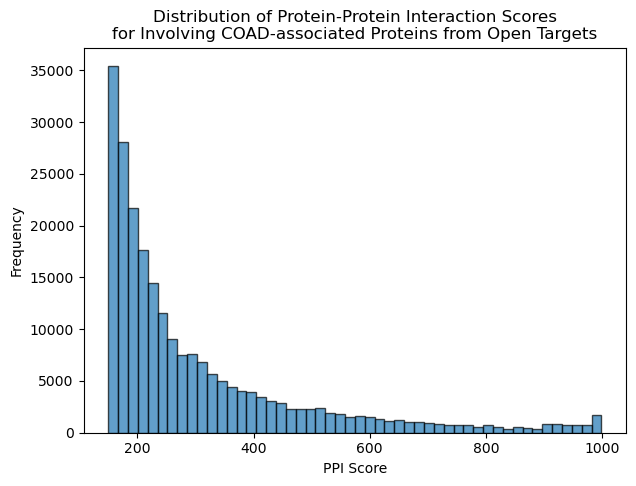

In [9]:
plot_score_distribution(scores)

I'm arbitrarily using 400 as a cutoff for considering an interaction significant. I understand that this isn't super statistically rigorous. This can be the focus of future improvements to the approach

In [10]:
def filter_by_score(
    input_file: str,
    output_file: str,
    threshold: float,
    delimiter: str = " "
) -> Set[str]:
    """
    Filter a subsetted PPI file by score threshold and collect unique proteins.

    Args:
        input_file: Path to the subsetted PPI file (with header).
        output_file: Path to save the filtered results.
        threshold: Minimum score to keep.
        delimiter: Column separator (default: space).
    
    Returns:
        A set of unique protein IDs present in the filtered file.
    """
    unique_proteins: Set[str] = set()

    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        header = infile.readline().strip()
        outfile.write(header + "\n")

        for line in infile:
            parts = line.strip().split(delimiter)
            if len(parts) < 3:
                continue
            p1, p2, score_str = parts
            score = float(score_str)

            if score >= threshold:
                outfile.write(line)
                unique_proteins.update([p1, p2])

    return unique_proteins

In [11]:
unique_protein_IDs = filter_by_score(input_file="./open.targets.COAD.associated.protein.links.txt", 
                output_file="./open.targets.COAD.associated.protein.links.filtered.txt", threshold=400)

In [12]:
stringDB_protein_IDs = [prot for prot in unique_protein_IDs]

## Cross referencing these against proteins in phosphoproteomic data

Since the goal is to use this knowledge graph for graph neural network models that take CPTAC-COAD data, we need to make sure to subset the interaction network to only contain those pairs for which we have experimental measurements. Here, I'll subset the list of links such that both interaction partners have measurements in CPTAC phosphoprot

In [13]:
### modify the file path here!!!
phosphoproteome = pd.read_csv("./COAD/COAD_phospho_site_abundance_log2_reference_intensity_normalized_Tumor.txt",
                             sep="\t", index_col=0).T

In [14]:
phosphoproteome

idx,ENSG00000004776.13|ENSP00000004982.3|S16|PSWLRRASAPLPGLS|1,ENSG00000006453.14|ENSP00000005260.8|S331|PSLQRSVSVATGLNM|1,ENSG00000006025.12|ENSP00000007414.3|S272|RVGRLHGSVPNLSRY|1,ENSG00000012983.11|ENSP00000013125.4|S335|ARAERTASEINFDKL|1,ENSG00000011304.20|ENSP00000014112.5|S141|KELKTDSSPNQARAQ|1,ENSG00000013588.9|ENSP00000014914.6|S345|PRAHAWPSPYKDYEV|1,ENSG00000038219.13|ENSP00000040738.5|S1531|KDKDVTLSPVKAGPA|1,ENSG00000038219.13|ENSP00000040738.5|S3019|QRSKTQLSPSIKRKR|1,ENSG00000057294.15|ENSP00000070846.6|S135|AQYSSQKSVEERSLR|1,ENSG00000057294.15|ENSP00000070846.6|S140|QKSVEERSLRHPLRR|1,...,ENSG00000270647.6|ENSP00000474096.1|S180|DNRGYGGSQGGGRGR|1,ENSG00000108819.11|ENSP00000478767.1|T193|VVRFNGSTEALDKLD|1,ENSG00000275342.5|ENSP00000481109.1|S837|GFFWTQGSPKPGTAS|1,ENSG00000263465.4|ENSP00000480140.1|S191|RYGGSHYSSSGYSNS|1,ENSG00000277363.5|ENSP00000484715.1|S331|SPSRSRLSYAGGRPP|1,ENSG00000277363.5|ENSP00000484715.1|S339|YAGGRPPSYAGSPVH|1,ENSG00000277363.5|ENSP00000484715.1|S436|RGSVRSLSTYSAAAL|1,ENSG00000267534.4|ENSP00000496438.1|S330|HHLLPLRSSSSLERG|1,ENSG00000267534.4|ENSP00000496438.1|S331|HLLPLRSSSSLERGM|1,ENSG00000023839.12|ENSP00000497274.1|S283|LNKNQSQSQDALVLE|1
01CO008,25.499300,21.442165,22.467814,21.540885,23.470425,20.472603,21.082442,22.022643,25.119845,19.488927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22CO006,25.858721,22.092910,22.001594,23.458847,24.261314,21.680794,21.369063,21.781979,23.955627,19.221020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05CO002,26.298141,23.120176,21.863230,23.225645,26.158287,21.271813,22.111900,22.091769,26.030249,20.445961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11CO036,25.671725,21.958060,21.925101,22.506026,24.193130,20.748930,21.318367,21.877974,25.102957,19.569117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20CO006,24.521099,21.725026,22.160339,21.686158,24.031382,21.834750,21.494902,22.205465,25.328575,20.358563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06CO002,27.048982,21.590918,22.114370,23.641799,25.217291,22.333490,21.644879,21.732062,26.019646,21.982558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16CO003,28.063537,22.147936,22.565030,22.615695,24.453184,22.252558,21.281548,21.941507,25.186252,20.521265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11CO070,27.028955,21.271127,22.293576,23.542531,24.937273,21.636570,21.953620,22.226683,24.570266,20.277084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05CO033,27.136662,21.845317,22.453521,23.360844,24.551381,22.496626,21.466962,21.694522,25.204329,20.905905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cptac_protein_IDS = [col.split("|")[1] for col in phosphoproteome.columns]
cptac_protein_IDS = ["9606."+prot.split(".")[0] for prot in cptac_protein_IDS]

In [16]:
len(set(stringDB_protein_IDs) & set(cptac_protein_IDS))

2281

Excellent: there are ~2,300 proteins in the protein-protein interaction network that are shared with the phosphoproteomic data. Since we can only model these genes with data from CPTAC, I'll create one further subset of the interaction network where both of the interacting genes are also present in the multi-omic data. 

In [17]:
scores_final = subset_interaction_db(input_file="./open.targets.COAD.associated.protein.links.filtered.txt",
                      output_file="./open.targets.COAD.associated.protein.links.cptac.txt",
                      proteins_of_interest=list(set(stringDB_protein_IDs) & set(cptac_protein_IDS)),
                      how='both')

In [18]:
print(f"Final PPI network generated with {len(scores_final)} edges \
and {len(set(stringDB_protein_IDs) & set(cptac_protein_IDS))} nodes.")

Final PPI network generated with 12604 edges and 2281 nodes.
